# Introduction

## Goals

- Find key drivers for Telco Churn
- Walkthrough the construction of a ML classfication Model
- Provide key points, explanations, and takeaways throughout the process.

In [207]:
# Standard Imports
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Modeling and Evalutation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Testing
import scipy.stats as stats

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Acquire & Prepare
from acquire import get_telco_data
from prepare import telco_split
import math

# Acquistion

In [2]:
# assigns the telco data as a Dataframe to a variable
telco = get_telco_data()
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [3]:
#summarize data
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
# statistical info for numeric variables (tenure and monthly charges)
# others are categorical
# total charges need to be changed to float (preparation)
telco[['tenure', 'monthly_charges']].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


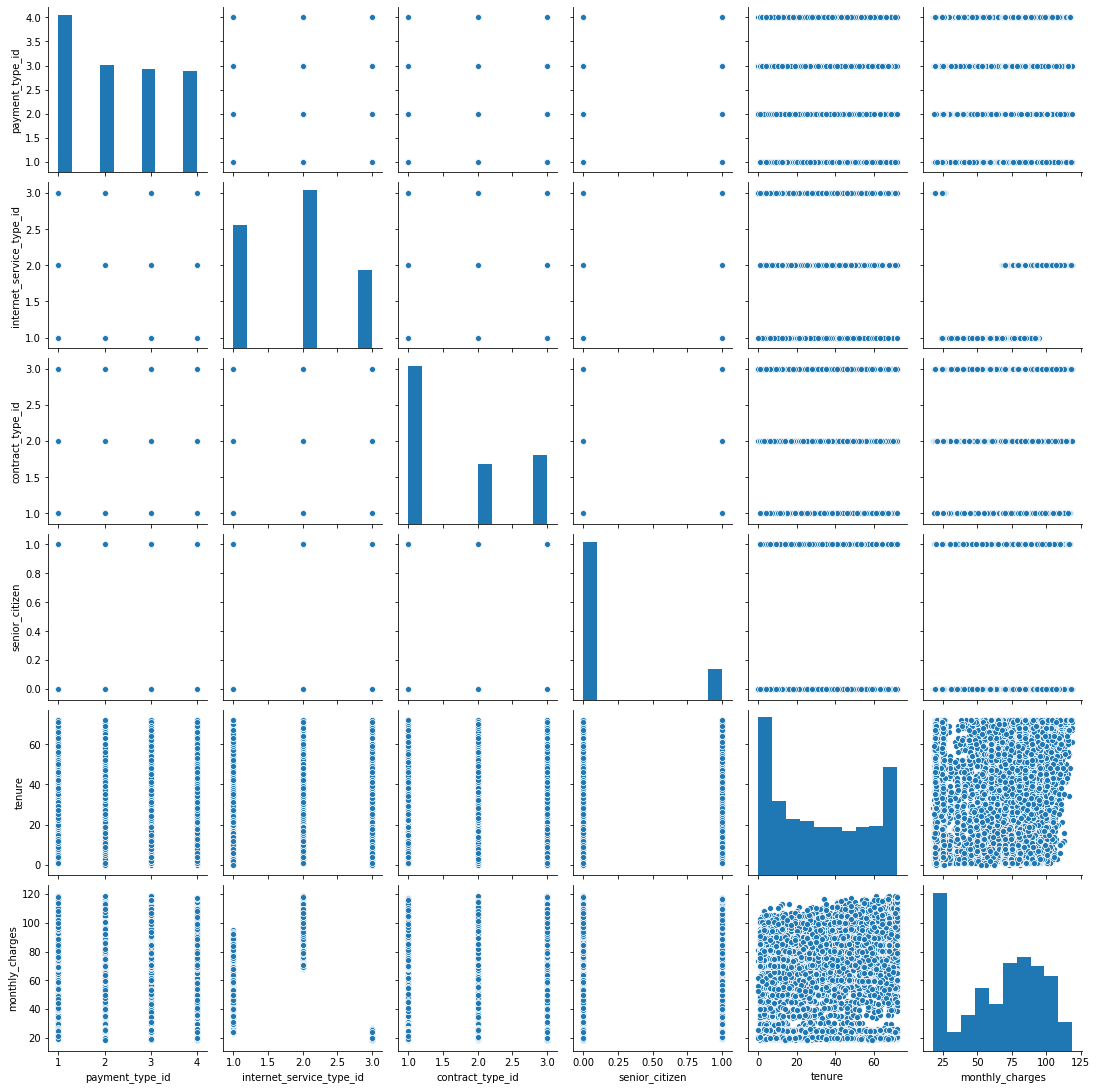

In [5]:
# plot individual distributions
sns.pairplot(telco)

# Preparation

#### Under the Hood:
- handle `total_charges` column
    - replace ' ' with *null* values (11 values)
    - change to **float** type
    - drop the *null* values 
        - only 0.16% of data
        - assuming new customers (tenure = 0)
        - **Bottom Line:** this data won't add value to our model
- **encode** categorical variables 
    - features (No/none: 0, Yes: 1)
        - `churn`
        - `paperless_billing`
        - `device_protection`
        - `tech_support`
        - `gender` -->` is_male` 
            - female: 0 
            - male: 1
        - `multiple_lines` --> `phone_lines`
            - none: 0
            - no (1 line): 1 
            - yes (2+ lines): 2
- **combine** 
    - features
        - `online_security` + `online_backup` --> `online_features`
            - value: number of features
        - `partner` + `dependents` --> `family`
            - value: number of family members
        - `streaming_tv` + `streaming_movies` --> `streaming_services`
            - value: number streaming services
- **eliminate** any redundant or implied values
    - features
        - `phone_service` (muliple_lines accounts for already)
        - `partner` (combined)
        - `dependents` (combined)
        - `streaming_tv` (combined)
        - `streaming_movies`(combined)
        - `online_security` (combined)
        - `online_backup` (combined)
- **change** internet_service_type_id
    - value
        - 3 -> 0 (represents 'None')
- **add** `tenure` (in years)

In [6]:
#change total_charges column to float type
telco.total_charges = telco.total_charges.replace(' ', np.nan).astype('float')

In [7]:
# assuming these are new customers who haven't paid/churned yet
# I will drop these observations as they only represent 0.16 % of the data, NBD
telco = telco.dropna()

In [8]:
#encode churn
telco['churn'] = telco.churn.map({'No': 0, 'Yes': 1})

#encode paperless billing 
telco['paperless_billing'] = telco.paperless_billing.map({'No': 0, 'Yes': 1})

#encode device_protection
telco['device_protection'] = telco.device_protection.map({'No internet service': 0, 'No': 0, 'Yes': 1})

#encode gender
telco['is_male'] = telco.gender.map({'Female': 0, 'Male': 1})

#encode multiple_lines
telco['phone_lines'] = telco.multiple_lines.map({'No phone service': 0, 'No': 1, 'Yes': 2})

#encode online_security
telco['online_security'] = telco.online_security.map({'No internet service': 0, 'No': 0, 'Yes': 1})

#encode online_backup
telco['online_backup'] = telco.online_backup.map({'No internet service': 0, 'No': 0, 'Yes': 1})

#encode partner
telco['partner'] = telco.partner.map({'No': 0, 'Yes': 1})

#encode dependents
telco['dependents'] = telco.dependents.map({'No': 0, 'Yes': 1})

#encode streaming_tv
telco['streaming_tv'] = telco.streaming_tv.map({'No internet service': 0, 'No': 0, 'Yes': 1})

#encode streaming_movies
telco['streaming_movies'] = telco.streaming_movies.map({'No internet service': 0, 'No': 0, 'Yes': 1})

#encode tech_support
telco['tech_support'] = telco.tech_support.map({'No internet service': 0, 'No': 0, 'Yes': 1})

In [9]:
#combine partner + dependents
telco['family'] = telco.partner + telco.dependents

#combine streaming_tv + streaming_movies
telco['streaming_services'] = telco.streaming_tv + telco.streaming_movies

#combine online_security + online_backup
telco['online_services'] = telco.online_security + telco.online_backup

In [10]:
#add tenure_years
telco['tenure_years'] = telco.tenure.apply(lambda x: math.floor(x/12))

In [11]:
#change 'None':3 to 0 (internet_service_type_id)
telco['internet_service_type_id'] = telco.internet_service_type_id.map({3: 0, 1: 1, 2: 2})

In [12]:
#drop columns
cols_to_drop = ['gender', \
                'multiple_lines',\
                'payment_type', \
                'internet_service_type', \
                'phone_service', \
                'contract_type', \
                'partner', 'dependents', \
                'streaming_tv', 'streaming_movies', \
                'online_security', \
                'online_backup']
telco = telco.drop(columns=cols_to_drop)

In [13]:
# Split on telco data, stratifying churn
# Return train, validate, and test as Dataframe.
def telco_split(df):
    train_validate, test = train_test_split(telco, test_size=.2, 
                                        random_state=369, 
                                        stratify=telco.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=369, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [14]:
train, validate, test = telco_split(telco)

In [15]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3937, 18)
validate -> (1688, 18)
test -> (1407, 18)


# Exploration

### Contract Type

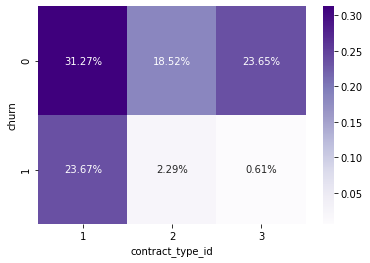

In [128]:
#churn by contract type: Month-to-Month (24% population)
sns.heatmap(pd.crosstab(train.churn, train.contract_type_id, normalize=True), annot=True, cmap='Purples', fmt='.2%')

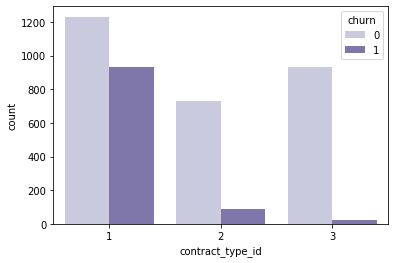

In [144]:
sns.countplot(x='contract_type_id', hue='churn', data=train, palette='Purples')

### Tech Support

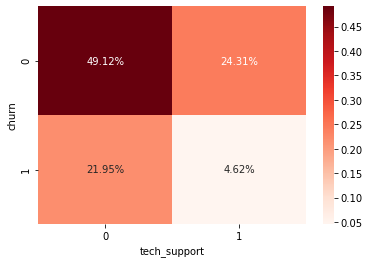

In [125]:
#churn by tech_support (22% of population)
sns.heatmap(pd.crosstab(train.churn, train.tech_support, normalize=True), annot=True, cmap='Reds', fmt='.2%')

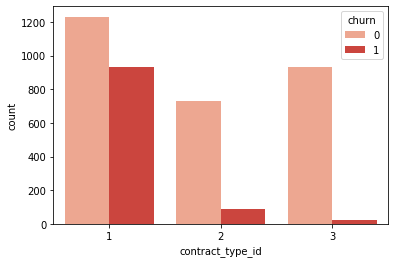

In [120]:
sns.countplot(x='tech_support', hue='churn', data=train, palette='Reds')

### Paperless Billing

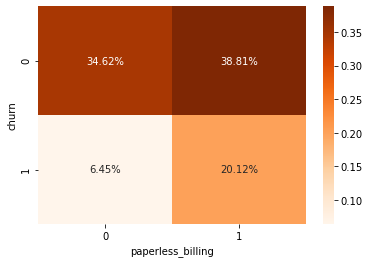

In [129]:
#churn by paperless_billing: with paperless (20% of population)
sns.heatmap(pd.crosstab(train.churn, train.paperless_billing, normalize=True), annot=True, cmap='Oranges', fmt='.2%')

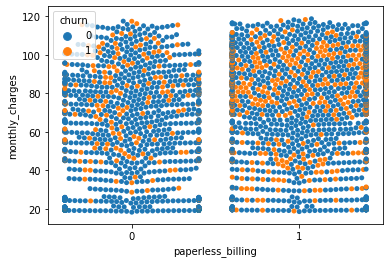

In [138]:
sns.swarmplot(x='paperless_billing', y='monthly_charges', data=train, hue='churn')

### Device Protection

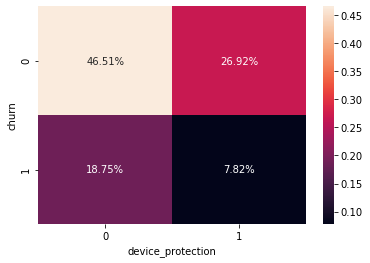

In [173]:
sns.heatmap(pd.crosstab(train.churn, train.device_protection, normalize=True), annot=True, fmt='.2%') 

### Internet Service Type

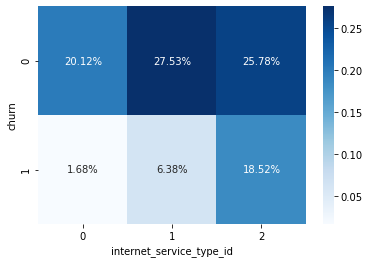

In [132]:
# churn by internet_type: fiber optic (19% population)
sns.heatmap(pd.crosstab(train.churn, train.internet_service_type_id, normalize=True), annot=True, cmap='Blues', fmt='.2%')

### Runner Ups

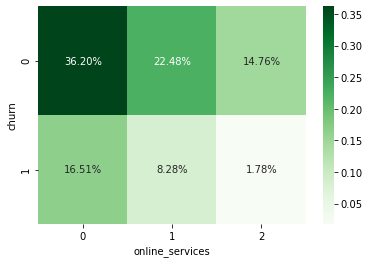

In [134]:
# churn by online_services: no online services (17% of population)
sns.heatmap(pd.crosstab(train.churn, train.online_services, normalize=True), annot=True, cmap='Greens', fmt='.2%')

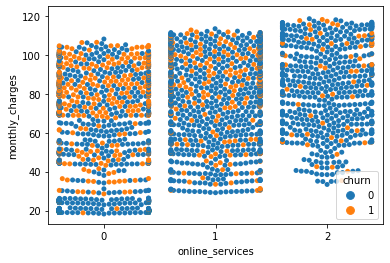

In [116]:
#online services
sns.swarmplot(x='online_services', y='monthly_charges', hue='churn', data=train)

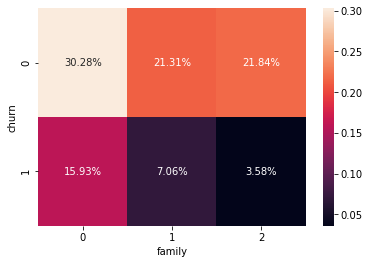

In [177]:
sns.heatmap(pd.crosstab(train.churn, train.family, normalize=True), annot=True, fmt='.2%') 

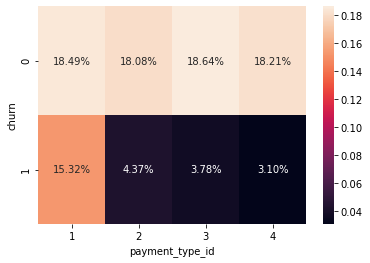

In [188]:
sns.heatmap(pd.crosstab(train.churn, train.payment_type_id, normalize=True), annot=True, fmt='.2%') 

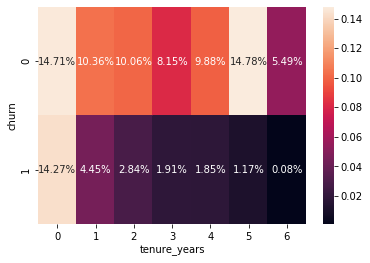

In [182]:
sns.heatmap(pd.crosstab(train.churn, train.tenure_years, normalize=True), annot=True, fmt='.2%') 

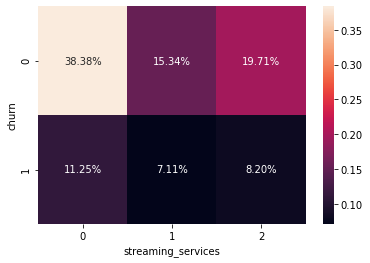

In [178]:
sns.heatmap(pd.crosstab(train.churn, train.streaming_services, normalize=True), annot=True, fmt='.2%')

#### Top Features (Drivers of Churn)
    1. contract_type_id:         Month-to-Month (24%)
    2. tech_support:             None (22%)
    3. paperless_billing:        Yes (20%)
    4. internet_service_type_id: Fiber Optic (20%)
    5. device_protection:        None (19%)

## Hypothesis Testing

### T-Test: 2-Sample, 2-Tailed 

In [40]:
churn_sample = train[train.churn == 1].monthly_charges
no_churn_sample = train[train.churn == 0].monthly_charges

In [163]:
# Hypotheses
H_o =  "Mean of monthly charges of churned customers = Mean of monthly charges of customers who haven't churned"
H_a =  "Mean of monthly charges of churned customers > Mean of monthly charges of customers who haven't churned"

# Alpha
alpha = .05

# Assumptions
print('Variances')
print('Churn Sample: ', churn_sample.var())
print('No Churn Sample: ', no_churn_sample.var(), '\n')

# Compute Test Statisic and P value
t, p = stats.ttest_ind(churn_sample, no_churn_sample, equal_var = False)
print('t-statistic: ', t, '\n', 'p-value: ', p/2, '\n')

# Decide
print('Conclusion:')
if p/2 > alpha:
    print("We fail to reject the null hypothesis that", H_o)
elif t < 0:
    print("We fail to reject the null hypothesis that", H_o)
else:
    print("We reject the null hypothesis that", H_o)

Variances
Churn Sample:  610.1931634662011
No Churn Sample:  979.5923204791418 

t-statistic:  13.932323073773787 
 p-value:  9.710562343444601e-43 

Conclusion:
We reject the null hypothesis that Mean of monthly charges of churned customers = Mean of monthly charges of customers who haven't churned


### Chi Square Test

In [192]:
#compare churn and streaming services
observed = pd.crosstab(train.churn, train.streaming_services)
observed

streaming_services,0,1,2
churn,,,
0,1511,604,776
1,443,280,323


In [186]:
# Hypothesis
H_o =  'churn is indepenent of streaming services'
H_a =  'churn is depenent on streaming services'

# Set Significance
alpha = .01

# Run the test
chi2, p, degf, expected = stats.chi2_contingency(observed)

# Decide
print('Conclusion:')
if p < alpha:
    print("We reject the null hypothesis that", H_o)
else:
    print("We fail to reject the null hypothesis")

print('p-value: ', p)

Conclusion:
We reject the null hypothesis that churn is indepenent of streaming services
p-value:  1.4391765803333994e-07


# Modeling

### Baseline

In [75]:
#find a baseline prediction: not churned is most frequent
train.churn.value_counts(normalize=True)

0    0.734315
1    0.265685
Name: churn, dtype: float64

In [76]:
#add baseline prediction to a column for comparison
train['baseline_prediction'] = 0

In [197]:
#Goal: Our model > 73.43% in terms of accuracy
baseline_accuracy = 1-train.churn.mean()
baseline_accuracy

0.7343154686309372

### Model 1

In [204]:
X_train = train[['contract_type_id', 'tech_support', 'paperless_billing', 'internet_service_type_id', 'device_protection', 'monthly_charges']]
y_train = train[['churn']]

X_validate = validate[['contract_type_id', 'tech_support', 'paperless_billing', 'internet_service_type_id', 'device_protection', 'monthly_charges']]
y_validate = validate[['churn']]

X_test = test[['contract_type_id', 'tech_support', 'paperless_billing', 'internet_service_type_id', 'device_protection', 'monthly_charges']]
y_test = test[['churn']]

In [231]:
#create a Logistic Regression Model, defaults
logit = LogisticRegression(random_state=123)

#fit the model to the train data
logit = logit.fit(X_train, y_train)

#examine coeffecients
print(logit.coef_)
print(X_train.columns)

#predict churn
y_pred = logit.predict(X_train)

#predict probability of churn
y_pred_proba = logit.predict_proba(X_train)

# Compute Accuracy
m1_acc = logit.score(X_train, y_train)
print(m1_acc)

#classification table for model 1
print(classification_report(y_train, y_pred))

[[-1.42920578 -0.38263966  0.45719661  1.02448689 -0.09756133 -0.00582058]]
Index(['contract_type_id', 'tech_support', 'paperless_billing',
       'internet_service_type_id', 'device_protection', 'monthly_charges'],
      dtype='object')
0.7787655575311151
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2891
           1       0.60      0.51      0.55      1046

    accuracy                           0.78      3937
   macro avg       0.71      0.69      0.70      3937
weighted avg       0.77      0.78      0.77      3937



### Model 2

In [236]:
from sklearn.ensemble import RandomForestClassifier

# Create Decision Tree Object, defaults
rf = RandomForestClassifier(max_depth=3, random_state=123)

# Fit model to training data
rf = rf.fit(X_train, y_train)

#Estimate Churn
y_pred2 = rf.predict(X_train)

# Estimate probability of Churn
y_pred_proba2 = rf.predict_proba(X_train)

# Compute Accuracy
m2_acc = rf.score(X_train, y_train)

print(m2_acc)
#classification table for model 2
print(classification_report(y_train, y_pred2))

0.7825755651511302
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2891
           1       0.62      0.46      0.53      1046

    accuracy                           0.78      3937
   macro avg       0.72      0.68      0.69      3937
weighted avg       0.77      0.78      0.77      3937



### Model 3

In [223]:
from sklearn.neighbors import KNeighborsClassifier

# create KNN object
knn = KNeighborsClassifier()

# Fit model to training data
knn = knn.fit(X_train, y_train)

# Estimate Churn
y_pred3 = knn.predict(X_train)
# Compute Accuracy
m3_acc = knn.score(X_train, y_train)

print(m3_acc)
#classification table for model 3
print(classification_report(y_train, y_pred3))

0.8234696469392939
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2891
           1       0.69      0.61      0.65      1046

    accuracy                           0.82      3937
   macro avg       0.78      0.76      0.77      3937
weighted avg       0.82      0.82      0.82      3937



# Evaluation

In [247]:
print("Train Accuracy: ")
print("model 1\n", logit.score(X_train, y_train))
print("model 2\n", rf.score(X_train, y_train))
print("model 3\n", knn.score(X_train, y_train), '\n')

print("Validate Accuracy: ")
print("model 1\n", logit.score(X_validate, y_validate))
print("model 2\n", rf.score(X_validate, y_validate))
print("model 3\n", knn.score(X_validate, y_validate))

Train Accuracy: 
model 1
 0.7787655575311151
model 2
 0.7825755651511302
model 3
 0.8234696469392939 

Validate Accuracy: 
model 1
 0.7523696682464455
model 2
 0.7505924170616114
model 3
 0.7381516587677726


In [252]:
print("Train classification report: ")
print("model 1\n", classification_report(y_train, y_pred))
print("model 2\n", classification_report(y_train, y_pred2))
print("model 3\n", classification_report(y_train, y_pred3), '\n')

y_pred_v = logit.predict(X_validate)
y_pred2_v = rf.predict(X_validate)
y_pred3_v = knn.predict(X_validate)

print("Validate classification report: ")
print("model 1\n", classification_report(y_validate, y_pred_v))
print("model 2\n", classification_report(y_validate, y_pred2_v))
print("model 3\n", classification_report(y_validate, y_pred3_v))

Train classification report: 
model 1
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      2891
           1       0.60      0.51      0.55      1046

    accuracy                           0.78      3937
   macro avg       0.71      0.69      0.70      3937
weighted avg       0.77      0.78      0.77      3937

model 2
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      2891
           1       0.62      0.46      0.53      1046

    accuracy                           0.78      3937
   macro avg       0.72      0.68      0.69      3937
weighted avg       0.77      0.78      0.77      3937

model 3
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      2891
           1       0.69      0.61      0.65      1046

    accuracy                           0.82      3937
   macro avg       0.78      0.76      0.77      3937
weighted avg     

**Best Model:**
- model 1
- consistency with evaluation metrics of train/validate 
- more generalizable, not overfit
- best scores overall

### Test

In [254]:
test_acc = logit.score(X_test, y_test)
y_pred_t = logit.predict(X_test)

print(test_acc)
print("test report:\n", classification_report(y_test, y_pred_t))

0.7810945273631841
test report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



# Conclusion